# Load and view an image

Let's start by defining some useful functions for later use.

In [ ]:
import numpy as np

import cv2
def load_from_disk(path):
  '''
  Loads and returns an image from disk,
  using the provided path
  '''
  return cv2.imread(path)

from PIL import Image
import requests
from io import BytesIO
def load_from_url(url):
  '''
  Loads and returns an image from the internet,
  using the provided URL
  '''
  response = requests.get(url)
  return np.asarray(Image.open(BytesIO(response.content)))

import matplotlib.pyplot as plt
def show(img, interpolation=None, axis=None):
  '''
  Displays an image with or without a color channel,
  '''
  cmap = 'gray' if len(img.shape) == 2 else None
  a = plt if axis is None else axis
  a.imshow(img, interpolation=interpolation, cmap=cmap)  # Draw image
  a.axis('off')  # We're not interested in image position here
  plt.tight_layout()
  if axis is None:
    plt.show()  # Show image

def show_ft(img_ft, interpolation=None, axis=None):
  '''
  For displaying a Fourier space image.
  '''
  ft = np.abs(img_ft)
  ft[ft > 0] = np.log(ft[ft > 0])
  show(ft, interpolation=interpolation, axis=axis)

Now we can use some of the functions to load an image into our current session.

Image shape: (700, 700, 3)


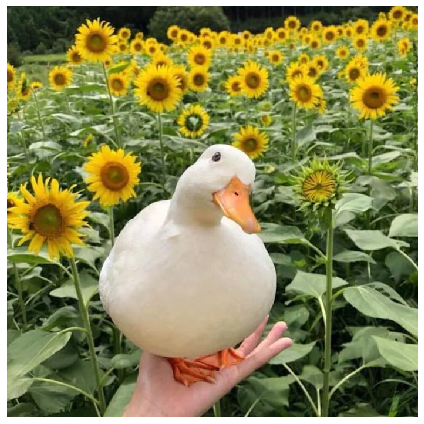

In [ ]:
# Duck
img = load_from_url('https://i.redd.it/9jk969nuxt331.jpg')

# Parot mango
#img = load_from_url('https://i.redd.it/wlpbt2nlqlz21.jpg')

# Mitotic Spindle
#img = load_from_url('https://i.pinimg.com/originals/4b/28/a5/4b28a5280c94b8d133659c644d7b2bde.jpg')

print("Image shape:", img.shape)  # Print the size of the image
plt.figure(figsize=(6,6))
show(img)

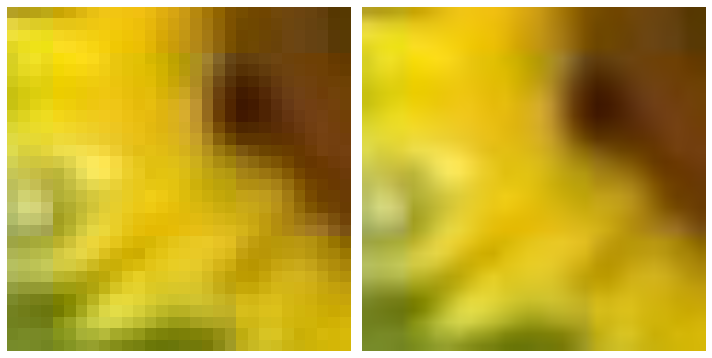

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,8))
show(img[140:170, 220:250], axis=ax1, interpolation='nearest')
show(img[140:170, 220:250], axis=ax2, interpolation='bilinear')

# Color Channels


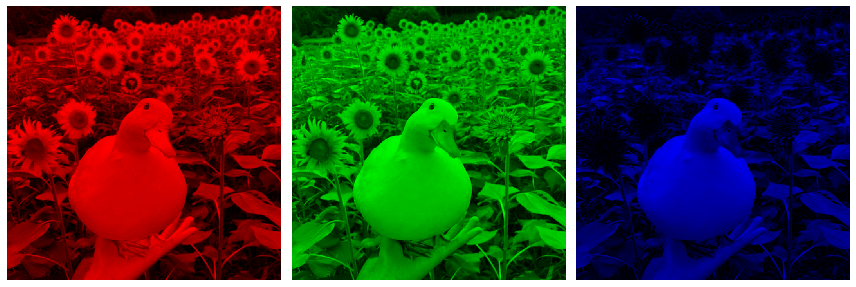

In [ ]:
# Red channel
R = np.zeros(img.shape).astype(np.uint8)
R[:, :, 0] = img[:, :, 0]

# Green channel
G = np.zeros(img.shape).astype(np.uint8)
G[:, :, 1] = img[:, :, 1]

# Blue channel
B = np.zeros(img.shape).astype(np.uint8)
B[:, :, 2] = img[:, :, 2]

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,8))

show(R, axis=ax1)
show(G, axis=ax2)
show(B, axis=ax3)

In [ ]:
# Calculate histogram of red channel
hist, bin_edges = np.histogram(img[:, :, 0], bins=20)
hist = hist / np.sum(hist) # Normalize to sum one
plt.plot(bin_edges[:-1], hist, 'r')

# Calculate histogram of green channel
hist, bin_edges = np.histogram(img[:, :, 1], bins=20)
hist = hist / np.sum(hist) # Normalize to sum one
plt.plot(bin_edges[:-1], hist, 'g')

# Calculate histogram of blue channel
hist, bin_edges = np.histogram(img[:, :, 2], bins=20)
hist = hist / np.sum(hist) # Normalize to sum one
plt.plot(bin_edges[:-1], hist, 'b')

# Calculate histogram of the average of all three channel
hist, bin_edges = np.histogram(np.mean(img, axis=2), bins=20)
hist = hist / np.sum(hist) # Normalize to sum one
plt.plot(bin_edges[:-1], hist, 'k')

plt.show()

To get a grayscale version of the image we have to reduce the three channels into a single gray-channels. This is usually done using the mean of the channels, but one can, depending on the application, choose other approaches, such as minimum and maximum values.

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(12,4))

# Mean
gimg = np.mean(img, axis=2)
show(gimg, axis=ax[0])

# Maximum
cmax_img = np.max(img, axis=2)
show(cmax_img, axis=ax[1])

# Minimum
cmin_img = np.min(img, axis=2)
show(cmin_img, axis=ax[2])

# Image operations

Let's try a simple image operation using the ndimage-library.

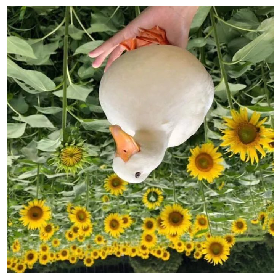

In [ ]:
from scipy import ndimage

# Rotate the image 45 degrees
rot_img = ndimage.rotate(img, 180)

show(rot_img)

Now have a look at the image in Fourier space and see what happens when you crop out high frequency Fourier component.

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

# Fourier transform the image
gimg_ft = np.fft.fft2(gimg)
gimg_ft = np.fft.fftshift(gimg_ft)

show_ft(gimg_ft, axis=ax1)

# Crop out a small box 60x60
sz = np.array(gimg_ft.shape) // 2
lps = 250//2
lp = np.zeros(gimg_ft.shape).astype(np.complex128)
lp[sz[0] - lps:sz[0] + lps, sz[1] - lps:sz[1] + lps] = \
  gimg_ft[sz[0] - lps:sz[0] + lps, sz[1] - lps:sz[1] + lps]

show_ft(lp, axis=ax2)

# Inverse Fourier transform the image and have a look
lp = np.fft.fftshift(lp)
show(np.fft.ifft2(lp).real, axis=ax3)

A better way to remove high frequency details is to convolve with a Gaussian. Lets create a 2D Gaussian.

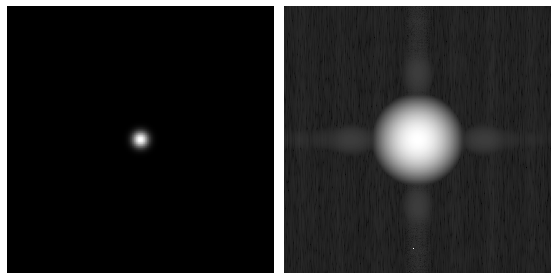

In [ ]:
from scipy import fftpack

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

# First a 1-D  Gaussian
t = np.linspace(-1, 1, 400)
bump = np.exp(-300*t**2)
bump /= np.sum(bump) # normalize the integral to 1

# make a 2-D kernel out of it
kernel = bump[:, np.newaxis] * bump[np.newaxis, :]
show(kernel, axis=ax1)

kernel_ft = np.fft.fft2(kernel, gimg_ft.shape)
show_ft(np.fft.fftshift(kernel_ft), axis=ax2)

If we multiply the Foruier transform of Gaussian and the image it is the same as convolving the two.

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4))

# Plot Fourier transform of our image
gimg_ft = np.fft.fft2(gimg)
show_ft(np.fft.fftshift(gimg_ft), axis=ax1)

# Apply low-pass and view
lp_ft = gimg_ft * (np.abs(kernel_ft))
lp = np.fft.ifft2(lp_ft).real
show(lp, axis=ax2)

# Apply high-pass and view
hp_ft = gimg_ft * (1-np.abs(kernel_ft))
hp = np.fft.ifft2(hp_ft).real
show(hp, axis=ax3)


# Noise

Now lets look at what noise can look like in an image by simulating it.

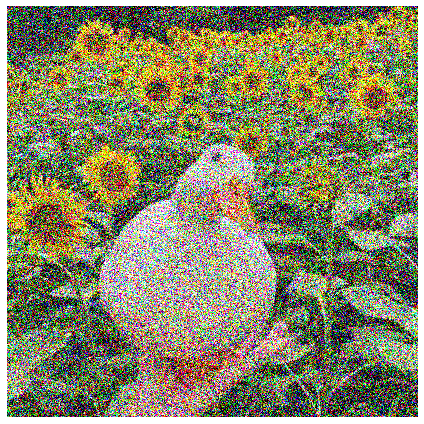

In [ ]:
# Let amke a copy of the original image
img_noise = np.copy(img).astype(np.float32)

# Add Gaussian noise twice the size of the standard deviation of the entire image
img_noise += img.std() * 2 * np.random.standard_normal(img.shape).astype(np.float32)

# Clip values out side the valid range of a color channel (0 to 255)
img_noise = np.clip(img_noise, 0, 255).astype(np.int)

plt.figure(figsize=(6,6))
show(img_noise)

The median filter is a type of image filter; usefull when you want to remove noise but preserve high frequency features. Let try this with shot noise instead of Gaussian noise.

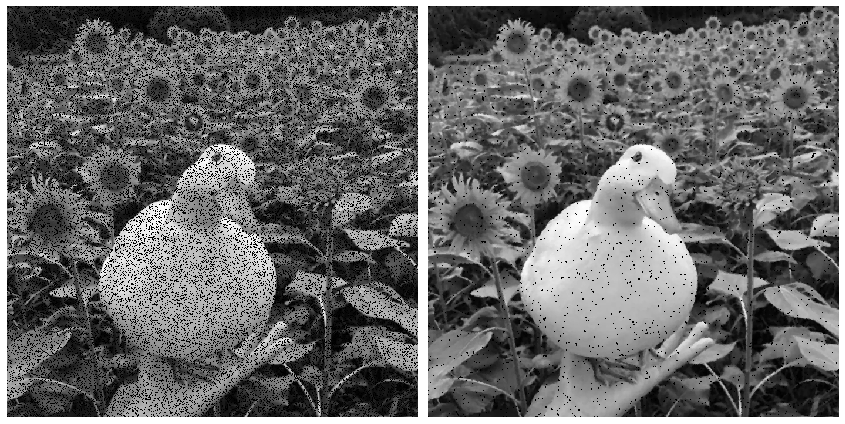

In [ ]:
# Copy original image
gimg_noise = np.copy(gimg)

# Generate random values
noise = np.random.uniform(size=gimg_noise.shape)

# Remove pixels at random positions with a 10% probability
gimg_noise[noise < 0.2] = 0

# Apply median filter
gimg_noise_medf = ndimage.median_filter(gimg_noise, 3)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
show(gimg_noise, axis=ax1)
show(gimg_noise_medf, axis=ax2)


In [ ]:
from scipy import ndimage
from scipy import signal

gimg_noise = np.copy(gimg)
gimg_noise += gimg.std() * 1 * np.random.standard_normal(gimg.shape)
gimg_blurred = ndimage.gaussian_filter(gimg_noise, sigma=3)
gimg_median = ndimage.median_filter(gimg_noise, size=5)
gimg_wiener = signal.wiener(gimg_noise, (5, 5))

fig, ax = plt.subplots(2,2, figsize=(10,10))
show(gimg_noise, axis=ax[0,0])
show(gimg_blurred, axis=ax[0,1])
show(gimg_median, axis=ax[1,0])
show(gimg_wiener, axis=ax[1,1])

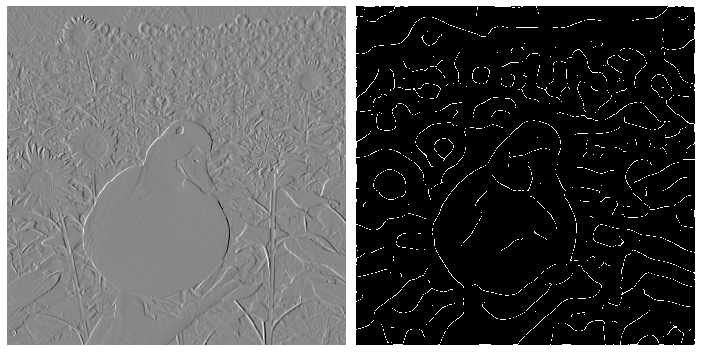

In [ ]:
from skimage import feature

fig, ax = plt.subplots(1,2, figsize=(10,5))
show(ndimage.sobel(gimg), axis=ax[0])
show(feature.canny(gimg, sigma=15), axis=ax[1])